# Benchmark Gehring & Homberger
## Capacitated Vehicle Routing Problem with Time Windows (CVRPTW)

While other notebooks such as [cvrptw_service_team_routing.ipynb](cvrptw_service_team_routing.ipynb) focus on the cuOpt API and high level problem modeling, here we focus on performance.

cuOpt offers a unique benefit over other solver_settings, specifically, time to solution.  In addition to achieving world class accuracy, cuOpt also produces these solutions in a time frame that allows for re-optimization in dynamic environments and rapid iteration over possible problem configurations.

Here we are demonstrating this performance on a large popular academic [dataset by Gehring & Homberger](https://www.sintef.no/projectweb/top/vrptw/homberger-benchmark/).  These problems are well studied and used as the basis for comparison for VRP research and product offerings. The particular instance we will test with is from the group of largest (1000 location) problems.  Each problem instance has an associated best known solution, the one we will measure against is shown below

**API Reference**: [cuOpt Documentation](https://docs.nvidia.com/cuopt)

### Environment Setup
First, let's check if we have a GPU available in system.

In [20]:
import subprocess
import html
from IPython.display import display, HTML

def check_gpu():
    try:
        result = subprocess.run(["nvidia-smi"], capture_output=True, text=True, timeout=5)
        result.check_returncode()
        lines = result.stdout.splitlines()
        gpu_info = lines[2] if len(lines) > 2 else "GPU detected"
        gpu_info_escaped = html.escape(gpu_info)
        display(HTML(f"""
        <div style="border:2px solid #4CAF50;padding:10px;border-radius:10px;background:#e8f5e9;">
            <h3>✅ GPU is enabled</h3>
            <pre>{gpu_info_escaped}</pre>
        </div>
        """))
        return True
    except (subprocess.CalledProcessError, subprocess.TimeoutExpired, FileNotFoundError, IndexError) as e:
        display(HTML("""
        <div style="border:2px solid red;padding:15px;border-radius:10px;background:#ffeeee;">
            <h3>⚠️ GPU not detected!</h3>
            <p>This notebook requires a <b>GPU runtime</b>.</p>

            <h4>If running in Google Colab:</h4>
            <ol>
              <li>Click on <b>Runtime → Change runtime type</b></li>
              <li>Set <b>Hardware accelerator</b> to <b>GPU</b></li>
              <li>Then click <b>Save</b> and <b>Runtime → Restart runtime</b>.</li>
            </ol>

            <h4>If running in Docker:</h4>
            <ol>
              <li>Ensure you have <b>NVIDIA Docker runtime</b> installed (<code>nvidia-docker2</code>)</li>
              <li>Run container with GPU support: <code>docker run --gpus all ...</code></li>
              <li>Or use: <code>docker run --runtime=nvidia ...</code> for older Docker versions</li>
              <li>Verify GPU access: <code>docker run --gpus all nvidia/cuda:12.0.0-base-ubuntu22.04 nvidia-smi</code></li>
            </ol>

            <p><b>Additional resources:</b></p>
            <ul>
              <li><a href="https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html" target="_blank">NVIDIA Container Toolkit Installation Guide</a></li>
            </ul>
        </div>
        """))
        return False

check_gpu()

True

#### Install dependencies


In [ ]:
# Enable this in case you are running this in google colab or such places where cuOpt is not yet installed
!pip uninstall -y cuda-python cuda-bindings cuda-core
!pip install --upgrade --extra-index-url=https://pypi.nvidia.com cuopt-cu12 nvidia-nvjitlink-cu12 rapids-logger==0.1.19
!pip install --upgrade --extra-index-url=https://pypi.nvidia.com cuopt-cu13 nvidia-nvjitlink-cu13 rapids-logger==0.1.19

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 27.5 MB/s eta 0:00:00
  Using cached cuda_python-12.9.4-py3-none-any.whl.metadata (4.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.4/380.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 448.8/637.8 MB 11.6 MB/s eta 0:00:17

# importing libreries


In [6]:
# Install notebook dependencyn
!pip install -q matplotlib scipy

In [7]:
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance
from cuopt import routing
import cudf
import matplotlib as plt

import os
import math
import pandas as pd
import numpy as np
import cudf
from cuopt import routing
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

ModuleNotFoundError: No module named 'cuopt'

# Functions

In [12]:
# Used to plot the Co-ordinates
def gen_plot(df):
    """
    Generate a plot with the locations.

    Args:
        df: DataFrame with location coordinates (xcord, ycord)

    Returns:
        matplotlib plot object
    """
    plt.figure(figsize=(11, 11))

    # Plot depot (first location)
    plt.scatter(
        df["xcord"][:1],
        df["ycord"][:1],
        label="Depot",
        color="Green",
        marker="o",
        s=100,
    )

    # Plot other locations
    plt.scatter(
        df["xcord"][1:],
        df["ycord"][1:],
        label="Locations",
        color="Red",
        marker="o",
        s=100,
    )

    plt.xlabel("x - axis")
    plt.ylabel("y - axis")
    plt.title("Simplified Map")
    plt.legend()

    # Add location labels
    for i, label in enumerate(df.index.values):
        plt.annotate(
            label,
            (df["xcord"][i], df["ycord"][i]),
            fontproperties=fm.FontProperties(size=16),
        )

    return plt


# Used to plot arrows
def add_arrows(df, route, plt, color="green"):
    """
    Add directional arrows to the plot to represent a route.

    Args:
        df: DataFrame with location coordinates
        route: List of location indices representing the route
        plt: matplotlib plot object
        color: Color for the arrows

    Returns:
        matplotlib plot object with arrows added
    """
    prev_cord = ()
    for i, label in enumerate(route):
        if i > 0:
            arrow_props = dict(
                arrowstyle="simple, head_length=0.5, head_width=0.5, tail_width=0.15",
                connectionstyle="arc3",
                color=color,
                mutation_scale=20,
                ec="black",
            )
            plt.annotate(
                "",
                xy=(df["xcord"][label], df["ycord"][label]),
                xytext=prev_cord,
                arrowprops=arrow_props,
                label=f"vehicle-{i}",
            )
        prev_cord = df["xcord"][label], df["ycord"][label]

    return plt


# Convert the solver response to a pandas dataframe for mapping
def get_solution_df(solution):
    """
    Converts a solution object to a pandas DataFrame

    Args:
        solution: A cuOpt routing.Solution object

    Returns:
        pandas.DataFrame: Contains the route information
    """
    # Check if it's a new API solution object
    if hasattr(solution, 'get_route'):
        # New API solution object
        routes_df = solution.get_route()
        return routes_df.to_pandas() if hasattr(routes_df, 'to_pandas') else routes_df

    # Check if it's a dictionary with vehicle_data key (legacy API)
    if isinstance(solution, dict) and "vehicle_data" in solution:
        solution_dict = solution["vehicle_data"]
        df = {}
        df["route"] = []
        df["truck_id"] = []
        df["location"] = []
        types = []

        for vid, route in solution_dict.items():
            df["location"] = df["location"] + route["route"]
            df["truck_id"] = df["truck_id"] + [vid] * len(route["route"])
            if "type" in list(route.keys()):
                types = types + route["type"]
        if len(types) != 0:
            df["types"] = types
        df["route"] = df["location"]

        return pd.DataFrame(df)

    # If solution is already a DataFrame, return it directly
    if isinstance(solution, pd.DataFrame):
        return solution

    # If we reach here, we don't recognize the format
    raise TypeError("Unrecognized solution format. Must be a Solution object, a response dictionary, or a DataFrame.")


# Prints vehicle routes
def show_vehicle_routes(solution, locations):
    """
    Print the vehicle routes in a readable format.

    Args:
        solution: cuOpt routing.Solution object
        locations: List of location names corresponding to indices
    """
    # Get route DataFrame from solution
    routes_df = solution.get_route()

    # Convert to pandas if it's a cudf DataFrame
    if hasattr(routes_df, 'to_pandas'):
        routes_df = routes_df.to_pandas()

    # Display routes for each vehicle
    for v_id in routes_df['truck_id'].unique():
        vehicle_route = routes_df[routes_df['truck_id'] == v_id]
        route_locations = vehicle_route['route'].tolist()

        print(f"For vehicle {v_id} route is:")
        path_parts = [locations[loc] for loc in route_locations]
        route_str = " → ".join(path_parts)
        print(route_str)
        print()


# Map vehicle routes
def map_vehicle_routes(df, solution, colors):
    """
    Creates a plot visualizing vehicle routes.

    Args:
        df: DataFrame with location coordinates
        solution: cuOpt routing.Solution object
        colors: List of colors to use for different vehicles

    Returns:
        matplotlib plot object with routes visualized
    """
    # Initialize plot with locations
    plt = gen_plot(df)

    # Get routes from solution
    routes_df = solution.get_route()

    # Convert to pandas if it's a cudf DataFrame
    if hasattr(routes_df, 'to_pandas'):
        routes_df = routes_df.to_pandas()

    # Get unique vehicle IDs
    vehicle_ids = routes_df['truck_id'].unique()

    # Create a mapping from vehicle ID to color index
    vid_map = {vid: i % len(colors) for i, vid in enumerate(vehicle_ids)}

    # Draw routes for each vehicle
    for v_id in vehicle_ids:
        v_route = routes_df[routes_df['truck_id'] == v_id]
        route_locs = v_route['route'].tolist()
        plt = add_arrows(
            df,
            route_locs,
            plt,
            color=colors[vid_map[v_id]]
        )

    return plt

In [13]:
# Timer setup
import time

class Stopwatch:
    """
    A simple stopwatch class to measure execution time of code blocks.
    Supports start, stop, reset, and elapsed time.
    """

    def __init__(self):
        self.start_time = None
        self.end_time = None
        self.running = False

    def start(self):
        """Start the stopwatch."""
        if not self.running:
            self.start_time = time.perf_counter()
            self.running = True
            print("⏱️ Stopwatch started...")
        else:
            print("⚠️ Stopwatch is already running!")

    def stop(self):
        """Stop the stopwatch and return elapsed time."""
        if self.running:
            self.end_time = time.perf_counter()
            self.running = False
            elapsed = self.end_time - self.start_time
            print(f"🛑 Stopwatch stopped. Elapsed time: {elapsed:.6f} seconds")
            return elapsed
        else:
            print("⚠️ Stopwatch is not running!")

    def reset(self):
        """Reset the stopwatch."""
        self.start_time = None
        self.end_time = None
        self.running = False
        print("🔁 Stopwatch reset.")

    def elapsed_time(self):
        """Get the current elapsed time without stopping."""
        if self.running:
            return time.perf_counter() - self.start_time
        elif self.start_time and self.end_time:
            return self.end_time - self.start_time
        else:
            return 0.0



# Data download / upload

In [14]:
#### Download the data
# Download benchmark data
# Create data directory if it doesn't exist
# !rm -rf /tmp/data
!mkdir -p /tmp/data
# !wget https://www.sintef.no/globalassets/project/top/vrptw/homberger/1000/homberger_1000_customer_instances.zip -O /tmp/data/homberger_data.zip

# Unzip the data
# !unzip /tmp/data/homberger_1000_customer_instances.zip -d /tmp/data/

best_known_solution = {
    "n_vehicles": 100,
    "cost": 42478.95
}



In [15]:

# Get the file path
homberger_1000_file = '/tmp/data/R1_10_6.TXT'  # /tmp/data/C1_10_1.TXT

# Check if the file exists
homberger_1000_file = '/tmp/data/R1_10_6.TXT'
# if not os.path.exists(homberger_1000_file):
#     raise FileNotFoundError(f"Could not find {homberger_1000_file}. Please check the path.")


# Problem Data
The data for this problem instance are provided via text file.  cuOpt has a utility function available specifically for the Gehring & Homberger benchmark which converts the problem into the components required by cuOpt.

In [16]:
def create_from_file(file_path, is_pdp=False):
    """
    Create a DataFrame from a problem file.

    Args:
        file_path: Path to the problem file
        is_pdp: Whether the file is a pickup and delivery problem

    Returns:
        Tuple of (df, vehicle_capacity, vehicle_num)
    """
    node_list = []
    with open(file_path, "rt") as f:
        count = 1
        for line in f:
            if is_pdp and count == 1:
                vehicle_num, vehicle_capacity, speed = line.split()
            elif not is_pdp and count == 5:
                vehicle_num, vehicle_capacity = line.split()
            elif is_pdp:
                node_list.append(line.split())
            elif count >= 10:
                node_list.append(line.split())
            count += 1

    vehicle_num = int(vehicle_num)
    vehicle_capacity = int(vehicle_capacity)

    columns = [
        "vertex",
        "xcord",
        "ycord",
        "demand",
        "earliest_time",
        "latest_time",
        "service_time",
        "pickup_index",
        "delivery_index",
    ]
    df = pd.DataFrame(columns=columns)

    for item in node_list:
        row = {
            "vertex": int(item[0]),
            "xcord": float(item[1]),
            "ycord": float(item[2]),
            "demand": int(item[3]),
            "earliest_time": int(item[4]),
            "latest_time": int(item[5]),
            "service_time": int(item[6]),
        }
        if is_pdp:
            row["pickup_index"] = int(item[7])
            row["delivery_index"] = int(item[8])
        df = pd.concat([df, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, vehicle_capacity, vehicle_num


In [17]:
orders, vehicle_capacity, n_vehicles = create_from_file(homberger_1000_file)
n_locations = orders["demand"].shape[0]-1
print("Number of locations          : ", n_locations)
print("Number of vehicles available : ", n_vehicles)
print("Capacity of each vehicle     : ", vehicle_capacity)
print("\nInitial Orders information")
print(orders)

/tmp/ipython-input-3088448605.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(row, index=[0])], ignore_index=True)


Number of locations          :  1000
Number of vehicles available :  250
Capacity of each vehicle     :  200

Initial Orders information
     vertex  xcord  ycord demand earliest_time latest_time service_time  \
0         0  250.0  250.0      0             0        1925            0   
1         1  171.0   34.0     21          1143        1173           10   
2         2   67.0  190.0     25          1173        1203           10   
3         3   80.0  400.0     10          1446        1476           10   
4         4  439.0  237.0     11           939         969           10   
...     ...    ...    ...    ...           ...         ...          ...   
996     996  413.0  345.0     20          1218        1248           10   
997     997  215.0  129.0     17          1119        1149           10   
998     998  380.0  350.0     15           866         896           10   
999     999   19.0   38.0     15           847         877           10   
1000   1000  166.0  247.0      1      

# Initialize cuOpt Problem Model

In [18]:
# Create a routing model with the necessary locations and vehicles
data_model = routing.DataModel(n_locations + 1, n_vehicles)

NameError: name 'routing' is not defined

### Cost Matrix

In [19]:
coords = location_coordinates = list(zip(orders['xcord'].to_list(),
                  orders['ycord'].to_list()))

cost_matrix = distance.cdist(coords, coords, 'euclidean')
cost_matrix_df = cudf.DataFrame(cost_matrix.astype(np.float32))

location_names = [
    "MFC", "L-1", "L-2", "L-3", "L-4", "L-5", "L-6", "L-7", "L-8", "L-9", "L-10", "L-11", "L-12", "L-13", "L-14", "L-15", "L-16", "L-17", "L-18", "L-19",
    "L-20", "L-21", "L-22", "L-23", "L-24", "L-25", "L-26", "L-27", "L-28", "L-29", "L-30", "L-31", "L-32", "L-33", "L-34", "L-35", "L-36", "L-37", "L-38", "L-39",
    "L-40", "L-41", "L-42", "L-43", "L-44", "L-45", "L-46", "L-47", "L-48", "L-49", "L-50", "L-51", "L-52", "L-53", "L-54", "L-55", "L-56", "L-57", "L-58", "L-59",
    "L-60", "L-61", "L-62", "L-63", "L-64", "L-65", "L-66", "L-67", "L-68", "L-69", "L-70", "L-71", "L-72", "L-73", "L-74", "L-75", "L-76", "L-77", "L-78", "L-79",
    "L-80", "L-81", "L-82", "L-83", "L-84", "L-85", "L-86", "L-87", "L-88", "L-89", "L-90", "L-91", "L-92", "L-93", "L-94", "L-95", "L-96", "L-97", "L-98", "L-99",
    "L-100", "L-101", "L-102", "L-103", "L-104", "L-105", "L-106", "L-107", "L-108", "L-109", "L-110", "L-111", "L-112", "L-113", "L-114", "L-115", "L-116", "L-117", "L-118", "L-119",
    "L-120", "L-121", "L-122", "L-123", "L-124", "L-125", "L-126", "L-127", "L-128", "L-129", "L-130", "L-131", "L-132", "L-133", "L-134", "L-135", "L-136", "L-137", "L-138", "L-139",
    "L-140", "L-141", "L-142", "L-143", "L-144", "L-145", "L-146", "L-147", "L-148", "L-149", "L-150", "L-151", "L-152", "L-153", "L-154", "L-155", "L-156", "L-157", "L-158", "L-159",
    "L-160", "L-161", "L-162", "L-163", "L-164", "L-165", "L-166", "L-167", "L-168", "L-169", "L-170", "L-171", "L-172", "L-173", "L-174", "L-175", "L-176", "L-177", "L-178", "L-179",
    "L-180", "L-181", "L-182", "L-183", "L-184", "L-185", "L-186", "L-187", "L-188", "L-189", "L-190", "L-191", "L-192", "L-193", "L-194", "L-195", "L-196", "L-197", "L-198", "L-199",
    "L-200", "L-201", "L-202", "L-203", "L-204", "L-205", "L-206", "L-207", "L-208", "L-209", "L-210", "L-211", "L-212", "L-213", "L-214", "L-215", "L-216", "L-217", "L-218", "L-219",
    "L-220", "L-221", "L-222", "L-223", "L-224", "L-225", "L-226", "L-227", "L-228", "L-229", "L-230", "L-231", "L-232", "L-233", "L-234", "L-235", "L-236", "L-237", "L-238", "L-239",
    "L-240", "L-241", "L-242", "L-243", "L-244", "L-245", "L-246", "L-247", "L-248", "L-249", "L-250", "L-251", "L-252", "L-253", "L-254", "L-255", "L-256", "L-257", "L-258", "L-259",
    "L-260", "L-261", "L-262", "L-263", "L-264", "L-265", "L-266", "L-267", "L-268", "L-269", "L-270", "L-271", "L-272", "L-273", "L-274", "L-275", "L-276", "L-277", "L-278", "L-279",
    "L-280", "L-281", "L-282", "L-283", "L-284", "L-285", "L-286", "L-287", "L-288", "L-289", "L-290", "L-291", "L-292", "L-293", "L-294", "L-295", "L-296", "L-297", "L-298", "L-299",
    "L-300", "L-301", "L-302", "L-303", "L-304", "L-305", "L-306", "L-307", "L-308", "L-309", "L-310", "L-311", "L-312", "L-313", "L-314", "L-315", "L-316", "L-317", "L-318", "L-319",
    "L-320", "L-321", "L-322", "L-323", "L-324", "L-325", "L-326", "L-327", "L-328", "L-329", "L-330", "L-331", "L-332", "L-333", "L-334", "L-335", "L-336", "L-337", "L-338", "L-339",
    "L-340", "L-341", "L-342", "L-343", "L-344", "L-345", "L-346", "L-347", "L-348", "L-349", "L-350", "L-351", "L-352", "L-353", "L-354", "L-355", "L-356", "L-357", "L-358", "L-359",
    "L-360", "L-361", "L-362", "L-363", "L-364", "L-365", "L-366", "L-367", "L-368", "L-369", "L-370", "L-371", "L-372", "L-373", "L-374", "L-375", "L-376", "L-377", "L-378", "L-379",
    "L-380", "L-381", "L-382", "L-383", "L-384", "L-385", "L-386", "L-387", "L-388", "L-389", "L-390", "L-391", "L-392", "L-393", "L-394", "L-395", "L-396", "L-397", "L-398", "L-399",
    "L-400", "L-401", "L-402", "L-403", "L-404", "L-405", "L-406", "L-407", "L-408", "L-409", "L-410", "L-411", "L-412", "L-413", "L-414", "L-415", "L-416", "L-417", "L-418", "L-419",
    "L-420", "L-421", "L-422", "L-423", "L-424", "L-425", "L-426", "L-427", "L-428", "L-429", "L-430", "L-431", "L-432", "L-433", "L-434", "L-435", "L-436", "L-437", "L-438", "L-439",
    "L-440", "L-441", "L-442", "L-443", "L-444", "L-445", "L-446", "L-447", "L-448", "L-449", "L-450", "L-451", "L-452", "L-453", "L-454", "L-455", "L-456", "L-457", "L-458", "L-459",
    "L-460", "L-461", "L-462", "L-463", "L-464", "L-465", "L-466", "L-467", "L-468", "L-469", "L-470", "L-471", "L-472", "L-473", "L-474", "L-475", "L-476", "L-477", "L-478", "L-479",
    "L-480", "L-481", "L-482", "L-483", "L-484", "L-485", "L-486", "L-487", "L-488", "L-489", "L-490", "L-491", "L-492", "L-493", "L-494", "L-495", "L-496", "L-497", "L-498", "L-499",
    "L-500", "L-501", "L-502", "L-503", "L-504", "L-505", "L-506", "L-507", "L-508", "L-509", "L-510", "L-511", "L-512", "L-513", "L-514", "L-515", "L-516", "L-517", "L-518", "L-519",
    "L-520", "L-521", "L-522", "L-523", "L-524", "L-525", "L-526", "L-527", "L-528", "L-529", "L-530", "L-531", "L-532", "L-533", "L-534", "L-535", "L-536", "L-537", "L-538", "L-539",
    "L-540", "L-541", "L-542", "L-543", "L-544", "L-545", "L-546", "L-547", "L-548", "L-549", "L-550", "L-551", "L-552", "L-553", "L-554", "L-555", "L-556", "L-557", "L-558", "L-559",
    "L-560", "L-561", "L-562", "L-563", "L-564", "L-565", "L-566", "L-567", "L-568", "L-569", "L-570", "L-571", "L-572", "L-573", "L-574", "L-575", "L-576", "L-577", "L-578", "L-579",
    "L-580", "L-581", "L-582", "L-583", "L-584", "L-585", "L-586", "L-587", "L-588", "L-589", "L-590", "L-591", "L-592", "L-593", "L-594", "L-595", "L-596", "L-597", "L-598", "L-599",
    "L-600", "L-601", "L-602", "L-603", "L-604", "L-605", "L-606", "L-607", "L-608", "L-609", "L-610", "L-611", "L-612", "L-613", "L-614", "L-615", "L-616", "L-617", "L-618", "L-619",
    "L-620", "L-621", "L-622", "L-623", "L-624", "L-625", "L-626", "L-627", "L-628", "L-629", "L-630", "L-631", "L-632", "L-633", "L-634", "L-635", "L-636", "L-637", "L-638", "L-639",
    "L-640", "L-641", "L-642", "L-643", "L-644", "L-645", "L-646", "L-647", "L-648", "L-649", "L-650", "L-651", "L-652", "L-653", "L-654", "L-655", "L-656", "L-657", "L-658", "L-659",
    "L-660", "L-661", "L-662", "L-663", "L-664", "L-665", "L-666", "L-667", "L-668", "L-669", "L-670", "L-671", "L-672", "L-673", "L-674", "L-675", "L-676", "L-677", "L-678", "L-679",
    "L-680", "L-681", "L-682", "L-683", "L-684", "L-685", "L-686", "L-687", "L-688", "L-689", "L-690", "L-691", "L-692", "L-693", "L-694", "L-695", "L-696", "L-697", "L-698", "L-699",
    "L-700", "L-701", "L-702", "L-703", "L-704", "L-705", "L-706", "L-707", "L-708", "L-709", "L-710", "L-711", "L-712", "L-713", "L-714", "L-715", "L-716", "L-717", "L-718", "L-719",
    "L-720", "L-721", "L-722", "L-723", "L-724", "L-725", "L-726", "L-727", "L-728", "L-729", "L-730", "L-731", "L-732", "L-733", "L-734", "L-735", "L-736", "L-737", "L-738", "L-739",
    "L-740", "L-741", "L-742", "L-743", "L-744", "L-745", "L-746", "L-747", "L-748", "L-749", "L-750", "L-751", "L-752", "L-753", "L-754", "L-755", "L-756", "L-757", "L-758", "L-759",
    "L-760", "L-761", "L-762", "L-763", "L-764", "L-765", "L-766", "L-767", "L-768", "L-769", "L-770", "L-771", "L-772", "L-773", "L-774", "L-775", "L-776", "L-777", "L-778", "L-779",
    "L-780", "L-781", "L-782", "L-783", "L-784", "L-785", "L-786", "L-787", "L-788", "L-789", "L-790", "L-791", "L-792", "L-793", "L-794", "L-795", "L-796", "L-797", "L-798", "L-799",
    "L-800", "L-801", "L-802", "L-803", "L-804", "L-805", "L-806", "L-807", "L-808", "L-809", "L-810", "L-811", "L-812", "L-813", "L-814", "L-815", "L-816", "L-817", "L-818", "L-819",
    "L-820", "L-821", "L-822", "L-823", "L-824", "L-825", "L-826", "L-827", "L-828", "L-829", "L-830", "L-831", "L-832", "L-833", "L-834", "L-835", "L-836", "L-837", "L-838", "L-839",
    "L-840", "L-841", "L-842", "L-843", "L-844", "L-845", "L-846", "L-847", "L-848", "L-849", "L-850", "L-851", "L-852", "L-853", "L-854", "L-855", "L-856", "L-857", "L-858", "L-859",
    "L-860", "L-861", "L-862", "L-863", "L-864", "L-865", "L-866", "L-867", "L-868", "L-869", "L-870", "L-871", "L-872", "L-873", "L-874", "L-875", "L-876", "L-877", "L-878", "L-879",
    "L-880", "L-881", "L-882", "L-883", "L-884", "L-885", "L-886", "L-887", "L-888", "L-889", "L-890", "L-891", "L-892", "L-893", "L-894", "L-895", "L-896", "L-897", "L-898", "L-899",
    "L-900", "L-901", "L-902", "L-903", "L-904", "L-905", "L-906", "L-907", "L-908", "L-909", "L-910", "L-911", "L-912", "L-913", "L-914", "L-915", "L-916", "L-917", "L-918", "L-919",
    "L-920", "L-921", "L-922", "L-923", "L-924", "L-925", "L-926", "L-927", "L-928", "L-929", "L-930", "L-931", "L-932", "L-933", "L-934", "L-935", "L-936", "L-937", "L-938", "L-939",
    "L-940", "L-941", "L-942", "L-943", "L-944", "L-945", "L-946", "L-947", "L-948", "L-949", "L-950", "L-951", "L-952", "L-953", "L-954", "L-955", "L-956", "L-957", "L-958", "L-959",
    "L-960", "L-961", "L-962", "L-963", "L-964", "L-965", "L-966", "L-967", "L-968", "L-969", "L-970", "L-971", "L-972", "L-973", "L-974", "L-975", "L-976", "L-977", "L-978", "L-979",
    "L-980", "L-981", "L-982", "L-983", "L-984", "L-985", "L-986", "L-987", "L-988", "L-989", "L-990", "L-991", "L-992", "L-993", "L-994", "L-995", "L-996", "L-997", "L-998", "L-999","L-100"
    ]


print("number of location's name given : " + str(len(location_names)) )
print("number of location's coordinates given : " + str(len(coords)) )
print(coords)



NameError: name 'cudf' is not defined

# plotting problem data

number of location's name given : 1001
number of location's coordinates given : 1001
['MFC', 'L-1', 'L-2', 'L-3', 'L-4', 'L-5', 'L-6', 'L-7', 'L-8', 'L-9', 'L-10', 'L-11', 'L-12', 'L-13', 'L-14', 'L-15', 'L-16', 'L-17', 'L-18', 'L-19', 'L-20', 'L-21', 'L-22', 'L-23', 'L-24', 'L-25', 'L-26', 'L-27', 'L-28', 'L-29', 'L-30', 'L-31', 'L-32', 'L-33', 'L-34', 'L-35', 'L-36', 'L-37', 'L-38', 'L-39', 'L-40', 'L-41', 'L-42', 'L-43', 'L-44', 'L-45', 'L-46', 'L-47', 'L-48', 'L-49', 'L-50', 'L-51', 'L-52', 'L-53', 'L-54', 'L-55', 'L-56', 'L-57', 'L-58', 'L-59', 'L-60', 'L-61', 'L-62', 'L-63', 'L-64', 'L-65', 'L-66', 'L-67', 'L-68', 'L-69', 'L-70', 'L-71', 'L-72', 'L-73', 'L-74', 'L-75', 'L-76', 'L-77', 'L-78', 'L-79', 'L-80', 'L-81', 'L-82', 'L-83', 'L-84', 'L-85', 'L-86', 'L-87', 'L-88', 'L-89', 'L-90', 'L-91', 'L-92', 'L-93', 'L-94', 'L-95', 'L-96', 'L-97', 'L-98', 'L-99', 'L-100', 'L-101', 'L-102', 'L-103', 'L-104', 'L-105', 'L-106', 'L-107', 'L-108', 'L-109', 'L-110', 'L-111', 'L-112', 'L-113'

/tmp/ipython-input-1558949160.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df["xcord"][i], df["ycord"][i]),


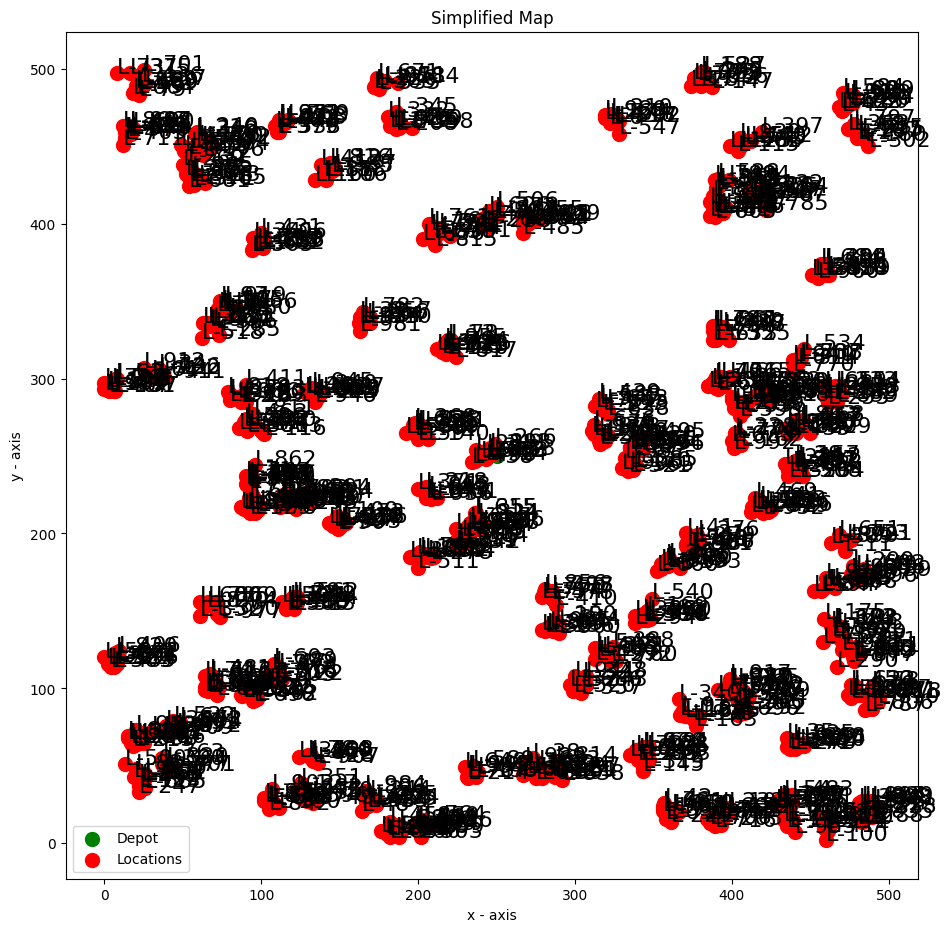

In [13]:

print("number of location's name given : " + str(len(location_names)) )
print("number of location's coordinates given : " + str(len(location_coordinates)) )

print(location_names)
print(location_coordinates)
location_coordinates_df = pd.DataFrame(location_coordinates, columns=['xcord', 'ycord'], index=location_names)
gen_plot(location_coordinates_df).show()

### Set Cost Matrix

In [14]:
# Add the distance matrix as our cost matrix
data_model.add_cost_matrix(cost_matrix_df)

### Set Fleet Data

In [15]:
# All vehicles start and end at the depot (location 0)
veh_start_locations = cudf.Series([0] * n_vehicles)
veh_end_locations = cudf.Series([0] * n_vehicles)
data_model.set_vehicle_locations(veh_start_locations, veh_end_locations)

# Set vehicle capacities
vehicle_capacities = cudf.Series([vehicle_capacity] * n_vehicles, dtype=np.int32)

### Set Demand and Capacity

In [16]:
# Convert demand to cudf Series
location_demand = cudf.Series(orders['demand'].values, dtype=np.int32)

# Add demand and capacity dimension
data_model.add_capacity_dimension("demand", location_demand, vehicle_capacities)

### Set Time Windows

In [17]:
# Set time windows for locations
earliest_times = cudf.Series(orders['earliest_time'].values, dtype=np.int32)
latest_times = cudf.Series(orders['latest_time'].values, dtype=np.int32)
data_model.set_order_time_windows(earliest_times, latest_times)

# Set service times
service_times = cudf.Series(orders['service_time'].values, dtype=np.int32)
data_model.set_order_service_times(service_times)

### Helper functions to solve and process the output

In [18]:
def solution_eval(vehicles, cost, best_known_solution):

    print(f"- cuOpt provides a solution using {vehicles} vehicles")
    print(f"- This represents {vehicles - best_known_solution['n_vehicles']} more than the best known solution")
    print(f"- Vehicle Percent Difference {(vehicles/best_known_solution['n_vehicles'] - 1)*100}% \n\n")
    print(f"- In addition cuOpt provides a solution cost of {cost}")
    print(f"- Best known solution cost is {best_known_solution['cost']}")
    print(f"- Cost Percent Difference {(cost/best_known_solution['cost'] - 1)*100}%")

### Get Optimized Results

Update solver config and test different run-time

**1 Minute Time Limit**

Note: due to the large amount of data network transfer time can exceed the requested solve time.


In [19]:
# Create solver settings with 60 second time limit
solver_settings = routing.SolverSettings()
solver_settings.set_time_limit(60.0)

# Solve the problem
solution = routing.Solve(data_model, solver_settings)

# Get solution metrics
if solution.get_status() == 0:  # Success
    num_vehicles = solution.get_vehicle_count()
    solution_cost = solution.get_total_objective()
    print(f"Solution found with status: {solution.get_status()}")
    print(f"Number of vehicles used: {num_vehicles}")
    print(f"Total solution cost: {solution_cost}")
else:
    print(f"Failed to find a solution. Status: {solution.get_status()}")

Solution found with status: 0
Number of vehicles used: 106
Total solution cost: 42539.291028380394


In [21]:
# Evaluation:
if solution.get_status() == 0:  # Success
    solution_eval(num_vehicles, solution_cost, best_known_solution)

NameError: name 'best_known_solution' is not defined

**2 Minute Time Limit**

In [ ]:
# Create solver settings with 120 second time limit
solver_settings = routing.SolverSettings()
solver_settings.set_time_limit(120.0)

# Solve the problem
solution = routing.Solve(data_model, solver_settings)

# Get solution metrics
if solution.get_status() == 0:  # Success
    num_vehicles = solution.get_vehicle_count()
    solution_cost = solution.get_total_objective()
    print(f"Solution found with status: {solution.get_status()}")
    print(f"Number of vehicles used: {num_vehicles}")
    print(f"Total solution cost: {solution_cost}")
else:
    print(f"Failed to find a solution. Status: {solution.get_status()}")


In [ ]:
solution.display_routes()








Vehicle-159 starts at: 0.0, completes at: 1285.13, travel time: 1285.13,  Route : 
0(Dpt)->164(D)->323(D)->242(D)->419(D)->179(D)->622(D)->450(D)->540(D)->0(Dpt) 

Vehicle-160 starts at: 0.0, completes at: 1544.95, travel time: 1544.95,  Route : 
0(Dpt)->487(D)->255(D)->899(D)->289(D)->572(D)->950(D)->423(D)->85(D)->554(D)->233(D)->881(D)->650(D)->0(Dpt) 

Vehicle-165 starts at: 0.0, completes at: 1540.79, travel time: 1540.79,  Route : 
0(Dpt)->35(D)->825(D)->932(D)->868(D)->154(D)->370(D)->827(D)->832(D)->270(D)->171(D)->146(D)->0(Dpt) 

Vehicle-166 starts at: 0.0, completes at: 1634.37, travel time: 1634.37,  Route : 
0(Dpt)->301(D)->777(D)->564(D)->320(D)->360(D)->763(D)->641(D)->284(D)->878(D)->0(Dpt) 

Vehicle-173 starts at: 0.0, completes at: 1227.35, travel time: 1227.35,  Route : 
0(Dpt)->122(D)->705(D)->316(D)->678(D)->461(D)->47(D)->773(D)->389(D)->603(D)->0(Dpt) 

Vehicle-175 starts at: 0.0, completes at: 914.4, travel time: 914.4,  Route : 
0(Dpt)->893(D)->0(Dpt) 

Vehicle

In [ ]:
# Evaluation:
if solution.get_status() == 0:  # Success
    solution_eval(num_vehicles, solution_cost, best_known_solution)

- cuOpt provides a solution using 108 vehicles
- This represents 8 more than the best known solution
- Vehicle Percent Difference 8.000000000000007% 


- In addition cuOpt provides a solution cost of 42572.421423316
- Best known solution cost is 42478.95
- Cost Percent Difference 0.22004174612604288%


# plot solution

In [22]:
def visualize_cvrp_solution(cuopt_solution, all_locations_coords, depot_location_index=0):
    """
    Visualize cuOpt CVRP solution with routes and statistics

    Parameters:
    -----------
    cuopt_solution : cuopt.routing.Solution
        The cuOpt solver solution object.
    all_locations_coords : array-like
        Coordinates of all locations (including depot at depot_location_index).
        e.g., [[depot_x, depot_y], [task1_x, task1_y], ...]
    depot_location_index : int, optional
        The index of the depot in all_locations_coords. Defaults to 0.
    """

    # Extract solver response metrics
    num_vehicles = cuopt_solution.get_vehicle_count()
    solution_cost = cuopt_solution.get_total_objective()
    solution_status = cuopt_solution.get_status()

    # Get routes data as pandas DataFrame
    routes_df = cuopt_solution.get_route().to_pandas()

    # Set depot location and task locations (customers)
    depot_location = all_locations_coords[depot_location_index]
    # Filter out depot from task_locations for plotting if it's also in task_locations
    task_locations = np.array([loc for i, loc in enumerate(all_locations_coords) if i != depot_location_index])

    # Create color palette for vehicles
    colors = plt.cm.tab20(np.linspace(0, 1, max(num_vehicles, 1)))

    # Create figure with subplots
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[3, 1], width_ratios=[2, 1])

    ax_main = fig.add_subplot(gs[0, :])
    ax_stats = fig.add_subplot(gs[1, 0])
    ax_legend = fig.add_subplot(gs[1, 1])

    # --- Main Route Visualization ---
    ax_main.set_title(f'cuOpt CVRP Solution - {num_vehicles} Vehicle(s), Total Cost: {solution_cost:.2f}',
                      fontsize=16, fontweight='bold', pad=20)

    # Plot depot
    ax_main.scatter(depot_location[0], depot_location[1],
                   c='red', s=400, marker='s',
                   edgecolors='darkred', linewidths=2,
                   label='Depot', zorder=5)

    # Plot task locations
    # Assuming task_locations here are only customer locations (excluding depot)
    # If all_locations_coords includes depot, filter it out for this scatter plot
    ax_main.scatter([loc[0] for i, loc in enumerate(all_locations_coords) if i != depot_location_index],
                   [loc[1] for i, loc in enumerate(all_locations_coords) if i != depot_location_index],
                   c='lightblue', s=150, marker='o',
                   edgecolors='steelblue', linewidths=1.5,
                   label='Customers', zorder=3)

    # Annotate task locations (excluding depot)
    customer_idx_map = {idx: original_idx for original_idx, idx in enumerate(range(len(all_locations_coords))) if original_idx != depot_location_index}

    for original_idx, (x, y) in enumerate(all_locations_coords):
        if original_idx != depot_location_index:
            ax_main.annotate(str(original_idx), (x, y), fontsize=8,
                            ha='center', va='center', fontweight='bold')


    # Statistics storage
    vehicle_stats = []

    # Group routes by vehicle
    for vehicle_idx, (vehicle_id, v_data) in enumerate(routes_df.groupby('truck_id')):
        route = v_data['route'].tolist()
        arrival_stamps = v_data.get('arrival_stamp', pd.Series()).tolist()
        task_ids = v_data.get('task_id', pd.Series()).tolist()
        types = v_data.get('type', pd.Series()).tolist()

        # Build route coordinates
        route_coords = []
        for loc_idx in route:
            route_coords.append(all_locations_coords[loc_idx])

        route_coords = np.array(route_coords)

        # Plot route
        color = colors[vehicle_idx % len(colors)]
        ax_main.plot(route_coords[:, 0], route_coords[:, 1],
                    color=color, linewidth=2.5, alpha=0.7,
                    marker='o', markersize=6, label=f'Vehicle {vehicle_id}')

        # Add arrows to show direction
        for i in range(len(route_coords) - 1):
            dx = route_coords[i+1, 0] - route_coords[i, 0]
            dy = route_coords[i+1, 1] - route_coords[i, 1]
            ax_main.arrow(route_coords[i, 0], route_coords[i, 1],
                         dx*0.3, dy*0.3, head_width=0.8, head_length=0.5,
                         fc=color, ec=color, alpha=0.5, zorder=2)

        # Calculate vehicle statistics
        # Filter out depot entries for route length calculation
        route_length = len([r for r in route if r != depot_location_index])

        # Calculate total time for the route if arrival stamps are available
        total_time = 0.0
        if arrival_stamps and len(arrival_stamps) > 1:
            # Assuming arrival_stamps corresponds to the route points directly
            # If arrival_stamps are for tasks, adjust logic. Here, assuming for route points.
            total_time = arrival_stamps[-1] - arrival_stamps[0]

        vehicle_stats.append({
            'Vehicle': f'V-{vehicle_id}',
            'Stops': route_length,
            'Total Time': f'{total_time:.1f}',
            'Sequence': ' → '.join([str(r) for r in route])
        })

    ax_main.set_xlabel('X Coordinate', fontsize=12)
    ax_main.set_ylabel('Y Coordinate', fontsize=12)
    ax_main.grid(True, alpha=0.3, linestyle='--')
    # Legend might become too crowded for 100 vehicles, consider alternatives
    # For now, keep it if not too many vehicles
    if num_vehicles < 20: # Arbitrary limit for readable legend
        ax_main.legend(loc='upper right', fontsize=10, framealpha=0.9)
    else:
        ax_main.legend([],[], frameon=False) # Hide legend if too many vehicles

    # --- Statistics Table ---
    ax_stats.axis('off')

    # Create statistics DataFrame
    stats_df = pd.DataFrame(vehicle_stats)

    # Display table
    table = ax_stats.table(cellText=stats_df.values,
                          colLabels=stats_df.columns,
                          cellLoc='left',
                          loc='center',
                          colWidths=[0.15, 0.15, 0.15, 0.55])

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    # Style header
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_facecolor('#218089')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#f5f5f5' if i % 2 == 0 else 'white')

    ax_stats.set_title('Vehicle Route Statistics', fontsize=12, fontweight='bold', pad=10)

    # --- Legend/Summary ---
    ax_legend.axis('off')

    summary_text = f"""
    SOLUTION SUMMARY
    ═══════════════════

    Total Vehicles Used: {num_vehicles}
    Total Solution Cost: {solution_cost:.2f}
    Total Customers: {len(all_locations_coords) - 1} # Excluding depot
    Status: {'Optimal' if solution_status == 0 else 'Suboptimal'} # Assuming 0 is success

    Dropped Tasks: {len(cuopt_solution.get_dropped_tasks().to_pandas()['task_id']) if hasattr(cuopt_solution.get_dropped_tasks(), 'to_pandas') else 0}
    """

    ax_legend.text(0.1, 0.5, summary_text, fontsize=11,
                  verticalalignment='center', family='monospace',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

    plt.tight_layout()
    plt.show()

    # Print detailed route information
    print("\n" + "="*70)
    print("DETAILED ROUTE INFORMATION")
    print("="*70)

    for vehicle_id, v_data in routes_df.groupby('truck_id'):
        route = v_data['route'].tolist()
        arrival_stamps = v_data.get('arrival_stamp', pd.Series()).tolist()
        task_ids = v_data.get('task_id', pd.Series()).tolist()
        types = v_data.get('type', pd.Series()).tolist()

        print(f"\n🚗 Vehicle {vehicle_id}:")
        print(f"   Route: {' → '.join([str(r) for r in route])}")

        if arrival_stamps and len(arrival_stamps) > 0:
            print(f"   Timeline:")
            for i, loc in enumerate(route):
                # Ensure indices are within bounds for arrival_stamps, task_ids, types
                time_val = arrival_stamps[i] if i < len(arrival_stamps) else None
                # For task_id, use original location index if task_id not explicit
                tid_val = task_ids[i] if i < len(task_ids) and task_ids[i] is not None else loc
                ttype_val = types[i] if i < len(types) and types[i] is not None else ('Depot' if loc == depot_location_index else 'Delivery')

                time_str = f"{time_val:.2f}" if time_val is not None else "N/A"
                print(f"      {i+1}. Location {loc} (Task: {tid_val}, Type: {ttype_val}) - Arrival: {time_str}")

    print("\n" + "="*70)

print("✓ Visualization function defined successfully!")

✓ Visualization function defined successfully!


/tmp/ipython-input-1558949160.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (df["xcord"][i], df["ycord"][i]),
/tmp/ipython-input-1558949160.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prev_cord = df["xcord"][label], df["ycord"][label]
/tmp/ipython-input-1558949160.py:76: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy=(df["xcord"][label], df["ycord"][label]),
/usr/local/lib/python3.12/dist-packages/IPython/core/pyla

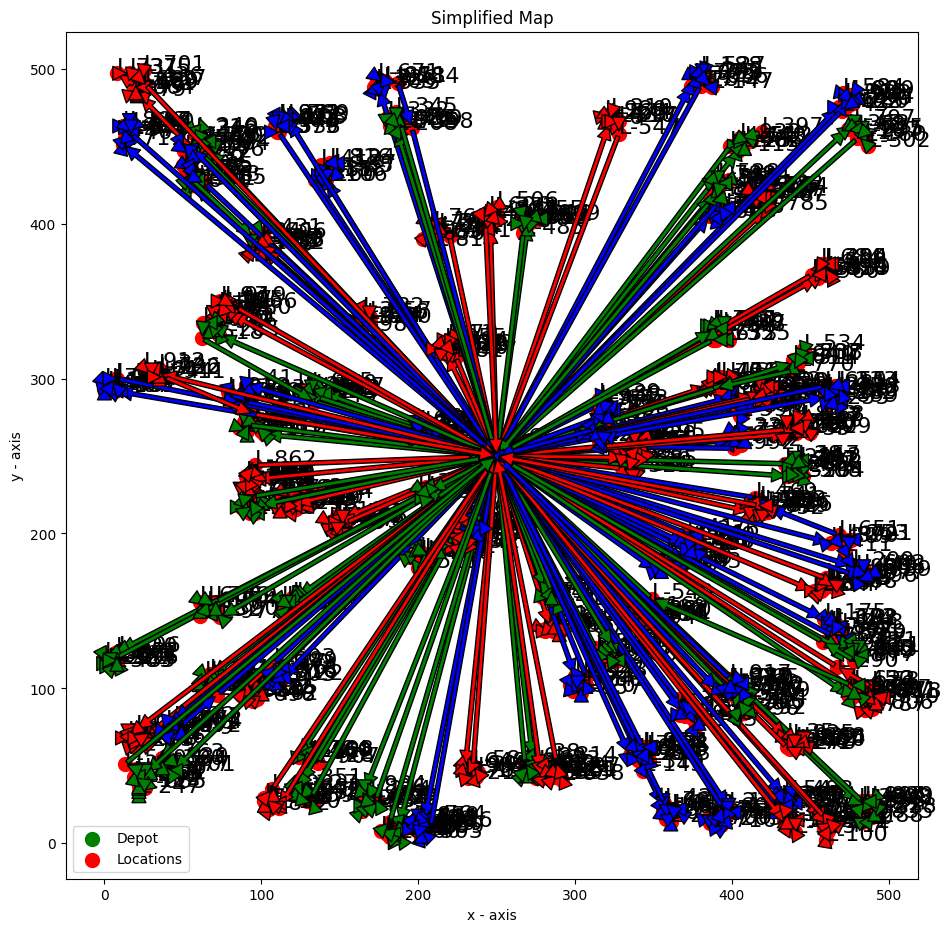

In [23]:

# Display the routes visually

vehicle_colors = ["red", "green", "blue"]

map_vehicle_routes(location_coordinates_df, solution, vehicle_colors).show()



SPDX-FileCopyrightText: Copyright (c) 2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved.

SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.